## 1D TFIM

Working with the Transverse Field Ising Model (TFIM).
The Hamiltonian has the following form:

$H = -J\sum_{i=1}^{N-1} \sigma_{i}^{z}\sigma_{i+1}^{z} - J\sigma_{N}^{z}\sigma_{1}^{z} - h\sum_{i = 1}^{N}\sigma_{i}^{x}$

(Note: The sum is over nearest neighbors, which is written as i, i+1 since we are looking specifically at 1D case. Since we are working with PBC, we can simply add the boundary term.)

## Step 1: Build Hamiltonian

In [179]:
function Hamiltonian(N,J,h)
    
    #Dimension of the Hilbert Space
    dim = (2)^N
    #Initialize a matrix for the Hamiltonian
    H = zeros(dim,dim)
    
    #Loop over the basis kets to construct the Hamiltonian
    #Basically, you know which inner products will contribute based on the form of H
    for ket in (0:dim-1)
        
        #Put ket in binary (printing purposes only)
        ket_binary = bitstring(ket)
        #Initialize the diagonal element of the matrix
        Diagonal = Int64(0)
        
        #Loop over each spin in the ket ad manipulate it as needed to construct the diagonal and off-diagonal 
        #pieces of the Hamiltonian
        for SpinIndex in (0:N-1) 
            #get the binary representation of the bit you are looking at
            bit = Int(2)^(SpinIndex)
            #XOR with ket 
            #This flips the spin corresponding to SpinIndex 
            #This generates the bras that will contribute via the transverse field
            bra = ket ⊻ bit
            #include the transverse field contributions to the Hamiltonian matrix
            H[bra+1,ket+1] += -h
            
            #For the last spin, calculate the periodic boundary term
            if SpinIndex == N-1
                S_last = 2*((ket>>SpinIndex)&1)-1
                S_first = 2*((ket>>(0))&1)-1
                Bond = J*S_last*S_first
                Diagonal += Bond
                break
            end
            
            #Calculate the diagonal term
            Si = 2*((ket>>SpinIndex)&1)-1
            Si_next = 2*((ket>>(SpinIndex+1))&1)-1
            Bond = J*Si*Si_next
            Diagonal += Bond
        end
        
        #Set the diagonal terms of the Hamiltonian
        H[ket+1,ket+1] += -1 * (Diagonal)
        
    end
    
    return H
    
end

Hamiltonian (generic function with 1 method)

##### Test this function to make sure it returns the proper Hamiltonian.

In [180]:
using LinearAlgebra

n_test = 3
j_test = 1
h_test = 0.1
Ham_test = Hamiltonian(n_test,j_test,h_test)

println("The Hamiltonian for N = ",n_test,", J = ",j_test,",and h = ",h_test," is")
show(stdout,"text/plain",Ham_test)

The Hamiltonian for N = 3, J = 1,and h = 0.1 is
8×8 Matrix{Float64}:
 -3.0  -0.1  -0.1   0.0  -0.1   0.0   0.0   0.0
 -0.1   1.0   0.0  -0.1   0.0  -0.1   0.0   0.0
 -0.1   0.0   1.0  -0.1   0.0   0.0  -0.1   0.0
  0.0  -0.1  -0.1   1.0   0.0   0.0   0.0  -0.1
 -0.1   0.0   0.0   0.0   1.0  -0.1  -0.1   0.0
  0.0  -0.1   0.0   0.0  -0.1   1.0   0.0  -0.1
  0.0   0.0  -0.1   0.0  -0.1   0.0   1.0  -0.1
  0.0   0.0   0.0  -0.1   0.0  -0.1  -0.1  -3.0

## Step 2: Diagonalize the Hamiltonian

In [188]:
using LinearAlgebra

n_diag = 2
j_diag = 1
h_diag = 1
Ham_diag = Hamiltonian(n_diag,j_diag,h_diag)

eigen_vals = eigvals(Ham_diag)
eigen_vals_n = eigen_vals/n_diag
eigen_vecs = eigvecs(Ham_diag)

println("For a Hamiltonian with N = ",n_diag,", J = ",j_diag,",and h = ",h_diag,", the eigenvalues are")
show(stdout,"text/plain",eigen_vals)
println("")
println("")
println("The scaled eigenvalues are")
show(stdout,"text/plain",eigen_vals_n)
println("")
println("")
println("With the following corresponding eigenvectors")
show(stdout,"text/plain",eigen_vecs)

For a Hamiltonian with N = 2, J = 1,and h = 1, the eigenvalues are
4-element Vector{Float64}:
 -2.8284271247461894
 -2.0000000000000004
  1.9999999999999996
  2.828427124746189

The scaled eigenvalues are
4-element Vector{Float64}:
 -1.4142135623730947
 -1.0000000000000002
  0.9999999999999998
  1.4142135623730945

With the following corresponding eigenvectors
4×4 Matrix{Float64}:
 0.653281   0.707107      4.44089e-16   0.270598
 0.270598   1.57009e-16   0.707107     -0.653281
 0.270598   3.14018e-16  -0.707107     -0.653281
 0.653281  -0.707107      0.0           0.270598

##### Check this diagonalization (ie does it reproduce original Hamiltonian)

In [189]:
S = eigen_vecs
D = diagm(eigen_vals)
S_inv = inv(S)

Ham_Repr = S*D*S_inv

show(stdout,"text/plain",Ham_Repr)

4×4 Matrix{Float64}:
 -2.0          -1.0          -1.0           1.20712e-16
 -1.0           2.0          -5.73317e-16  -1.0
 -1.0          -1.37213e-16   2.0          -1.0
  2.79071e-16  -1.0          -1.0          -2.0

##### Calculate the energy per spin

Dividing both sides of the Hamiltonian by J yields the Hamiltonian in units of J and gives us a tuneable parameter in front of the Transverse Field (h/J)

$\frac{H}{J} = -\sum_{i=1}^{N-1} \sigma_{i}^{z}\sigma_{i+1}^{z} - \sigma_{N}^{z}\sigma_{1}^{z} - \frac{h}{J}\sum_{i = 1}^{N}\sigma_{i}^{x}$

The energy depends on the state of the system, but diagonalizing the matrix produces the energy eigenstates (ie the whole spectrum of energies). To find the energy per spin, simply calculate the eigenvalues and divide by N.

In [201]:
N_Max = 5
N_range = range(2,N_Max,step=1) #|>collect (this prints out all the elements in this range)
h_J_range = range(0,2,step=0.1)

Es_per_spin = zeros((length(N_range),length(h_J_range),Int64(2)^N_Max))

for i in (1:length(N_range))
    for j in (1:length(h_J_range))
        n = N_range[i]
        h_j = h_J_range[j]
        Ham         = Hamiltonian(n,1,h_j)
        eigenvalues = eigvals(Ham)
        Es_per_spin[i,j,1:length(eigenvalues)] = eigenvalues/n
    end
end

In [198]:
#show(stdout,"text/plain",Es_per_spin)

##### Plot the ground state energy per spin (for varying system sizes) as a function of h/J

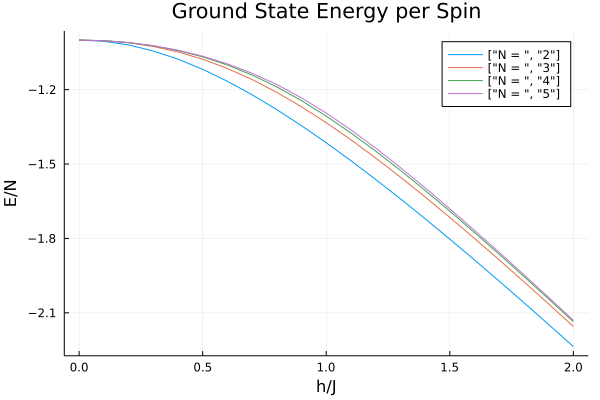

In [203]:
using Plots

Ground_States = Es_per_spin[:,:,1]
h_J_range = range(0,2,step=0.1)
N_range = range(2,N_Max,step=1)

plot(title = "Ground State Energy per Spin", xlabel = "h/J", ylabel = "E/N")

for i in (1:length(N_range))
    if i == length(N_range)
        display(plot!(h_J_range,Ground_States[i,:],label = ["N = ", N_range[i]]))
    else
        plot!(h_J_range,Ground_States[i,:],label = ["N = ", N_range[i]]);
    end
end
